In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math
from scipy.ndimage import gaussian_filter

In [ ]:
# #basic
def do_random_flip(image, mask):
    assert image.shape[:2] == mask.shape
    assert image.shape[0] == mask.shape[1]
    assert image.shape[0] == mask.shape[1]

    if np.random.rand() < 1:
        image = cv2.flip(image, 1)      # horizontal
        mask  = cv2.flip(mask, 1)
    
    # if np.random.rand() < 1:
    #     image = cv2.flip(image, 0)
    #     mask  = cv2.flip(mask, 0)

    # if np.random.rand() < 1:
    #     image = cv2.flip(image, -1)
    #     mask = cv2.flip(mask, -1)
        # image = image.transpose(1, 0, 2)
        # mask  = mask.transpose(1, 0)
    
    image = np.ascontiguousarray(image)
    mask  = np.ascontiguousarray(mask)
    return image, mask

In [ ]:
# #geometric
def affine_param_to_matrix(
    degree=10,
    scale=0.1,
    translate=(10,10),
    shear=(10,10),
):
    #h,w = image_shape
    #https://stackoverflow.com/questions/61242154/the-third-column-of-cv2-getrotationmatrix2d
    rotate = cv2.getRotationMatrix2D(angle=degree, center=(0, 0), scale=scale)

    # Shear
    shear_x = math.tan(shear[0] * math.pi / 180)
    shear_y = math.tan(shear[1] * math.pi / 180)

    matrix = np.ones([2, 3])
    matrix[0] = rotate[0] + shear_y * rotate[1]
    matrix[1] = rotate[1] + shear_x * rotate[0]
    matrix[0, 2] = translate[0]
    matrix[1, 2] = translate[1]
    return matrix


# np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
def do_random_affine(
    image,
    mask,
    degree=30,
    translate=0.1,
    scale=0.2,
    shear=10,
):
    assert image.shape[:2] == mask.shape
    assert image.shape[0] == mask.shape[1]
    assert image.shape[0] == mask.shape[1]

    h,w = image.shape[:2]
    degree = np.random.uniform(-degree, degree)
    scale  = np.random.uniform(-scale, scale)+1
    translate_x, translate_y  = np.random.uniform(-translate, translate,2)*[w,h]
    shear_x, shear_y  = np.random.uniform(-shear, shear,2)

    matrix = affine_param_to_matrix(
        degree,
        scale,
        (translate_x, translate_y),
        (shear_x, shear_y),
    )

    image = cv2.warpAffine( image, matrix, (w,h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    mask = cv2.warpAffine( mask, matrix, (w,h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    return image, mask

In [ ]:
def do_random_rotate(image, mask, degree=30, ):
    assert image.shape[:2] == mask.shape
    assert image.shape[0] == mask.shape[1]
    assert image.shape[0] == mask.shape[1]

    degree = np.random.uniform(-degree, degree)

    h, w = image.shape[:2]
    cx, cy = w // 2, h // 2
    matrix = cv2.getRotationMatrix2D((cx, cy), -degree, 1.0)
    image = cv2.warpAffine( image, matrix, (w,h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    mask = cv2.warpAffine( mask, matrix, (w,h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return image, mask

In [ ]:

def do_random_stretch(image, mask, stretch=(0.2,0.4) ):
    assert image.shape[:2] == mask.shape
    assert image.shape[0] == mask.shape[1]
    assert image.shape[0] == mask.shape[1]

    stretchx, stretchy = stretch
    stretchx = np.random.uniform(-stretchx, stretchx) + 1
    stretchy = np.random.uniform(-stretchy, stretchy) + 1

    matrix = np.array([
        [stretchy,0,0],
        [0,stretchx,1],
    ])
    h, w = image.shape[:2]
    image = cv2.warpAffine( image, matrix, (w,h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    mask = cv2.warpAffine( mask, matrix, (w,h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    return image, mask

In [ ]:
def do_random_contrast(image, mask):
    assert image.shape[:2] == mask.shape
    assert image.shape[0] == mask.shape[1]
    assert image.shape[0] == mask.shape[1]

    #image = image.astype(np.float32)/255
    u = np.random.choice(3)
    if u==0:
        m = np.random.uniform(-0.3,0.3)
        image = image*(1+m)
    if u==1:
        m = np.random.uniform(-0.5,0.5)
        image = image**(1+m)
    if u==2:
        m = np.random.uniform(-0.2,0.2)
        image = image + m

    image = np.clip(image,0,1)
    #image = (image*255).astype(np.uint8)
    return image, mask

In [ ]:
#noise
def do_random_noise(image, mask, m=0.8):
    assert image.shape[:2] == mask.shape
    assert image.shape[0] == mask.shape[1]
    assert image.shape[0] == mask.shape[1]

    height, width = image.shape

    #image = (image).astype(np.float32)/255
    noise = np.random.uniform(-1,1,size=(height,width))*m
    image = image+noise

    image = np.clip(image,0,1)
    #image = (image*255).astype(np.uint8)
    return image, mask

In [ ]:
def do_random_cutout(image, mask, num_block=5, block_size=[0.1,0.3], fill='constant'):
    assert image.shape[:2] == mask.shape
    assert image.shape[0] == mask.shape[1]
    assert image.shape[0] == mask.shape[1]

    height, width = image.shape[:2]

    num_block = np.random.randint(1,num_block+1)
    for n in range(num_block):
        h = np.random.uniform(*block_size)
        w = np.random.uniform(*block_size)
        h = int(h*height)
        w = int(w*width)
        x = np.random.randint(0,width-w)
        y = np.random.randint(0,height-h)
        if fill=='constant':
            image[y:y+h,x:x+w]=0
            mask[y:y+h,x:x+w]=0
        else:
            raise NotImplementedError
    return image, mask

In [ ]:
def do_elastic_transform(
    image,
    mask,
    alpha=120,
    sigma=120* 0.5,
    alpha_affine=120* 0.3

):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    Based on https://gist.github.com/ernestum/601cdf56d2b424757de5
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.
    """
    assert image.shape[:2] == mask.shape
    assert image.shape[0] == mask.shape[1]
    assert image.shape[0] == mask.shape[1]
    height, width = image.shape[:2]

    # Random affine
    center_square = np.array((height, width), dtype=np.float32) // 2
    square_size = min((height, width)) // 3
    alpha = float(alpha)
    sigma = float(sigma)
    alpha_affine = float(alpha_affine)

    pts1 = np.array(
        [
            center_square + square_size,
            [center_square[0] + square_size, center_square[1] - square_size],
            center_square - square_size,
        ],
        dtype=np.float32,
    )
    pts2 = pts1 + np.random.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(
        np.float32
    )
    matrix = cv2.getAffineTransform(pts1, pts2)

    image = cv2.warpAffine(image, M=matrix, dsize=(width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    mask = cv2.warpAffine(mask, M=matrix, dsize=(width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)


    if 1:
        dx = gaussian_filter((np.random.rand(height, width) * 2 - 1), sigma) * alpha
        dy = gaussian_filter((np.random.rand(height, width) * 2 - 1), sigma) * alpha


    x, y = np.meshgrid(np.arange(width), np.arange(height))
    map_x = np.float32(x + dx)
    map_y = np.float32(y + dy)
    image = cv2.remap( image, map1=map_x, map2=map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    mask = cv2.remap( mask, map1=map_x, map2=map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    return image, mask

In [ ]:
# import random
# def do_random_hsv(image, mask, mag=[0.15,0.25,0.25]):
#     image = (image*255).astype(np.uint8)
#     hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

#     h = hsv[:, :, 0].astype(np.float32)  # hue
#     s = hsv[:, :, 1].astype(np.float32)  # saturation
#     v = hsv[:, :, 2].astype(np.float32)  # value
#     h = (h*(1 + random.uniform(-1,1)*mag[0]))%180
#     s =  s*(1 + random.uniform(-1,1)*mag[1])
#     v =  v*(1 + random.uniform(-1,1)*mag[2])

#     hsv[:, :, 0] = np.clip(h,0,180).astype(np.uint8)
#     hsv[:, :, 1] = np.clip(s,0,255).astype(np.uint8)
#     hsv[:, :, 2] = np.clip(v,0,255).astype(np.uint8)
#     image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
#     image = image.astype(np.float32)/255
#     return image, mask

In [ ]:

# image = cv2.imread(imgfile, cv2.IMREAD_UNCHANGED)
# image.shape
# image = np.reshape(image, (1, image.shape[0], image.shape[1])).transpose((1,2,0))
# image.shape
# image = torch.from_numpy(image)
# image = image.expand(-1, -1, 1)
# image.shape
# image = image.numpy()


# mask = cv2.imread(pngfile, cv2.IMREAD_GRAYSCALE)
# mask.shape
# mask = np.reshape(mask, (1, mask.shape[0], mask.shape[1])).transpose(1, 2, 0)
# mask.shape
# image


img_file_path = f'/home/workspace/AMP_mysef_2D_Cls/data/png_img_Tr_nonzero/crc_008/crc_008_012.png'
mask_file_path = f'/home/workspace/AMP_mysef_2D_Cls/data/png_mask_Tr_nonzero/crc_008/crc_008_012.png'

image = cv2.imread(img_file_path, cv2.IMREAD_UNCHANGED)
# image = np.reshape(image, (image.shape[0], image.shape[1], 1))
# image.shape
# image = torch.from_numpy(image)
# image = image.expand(-1, -1, 1)
# image.shape
# image = image.numpy()
image = image.astype(np.float32) / 255.0
mask_file = cv2.imread(mask_file_path, cv2.IMREAD_UNCHANGED)


########### print shape ################
print(image.shape)
print(mask_file.shape)

############## subplot #################
plt.figure()
plt.subplot(221)
plt.imshow(image, cmap='gray')
 
plt.subplot(222)
plt.imshow(mask_file, cmap='gray')
plt.show()


In [ ]:
# img1, mask = do_random_flip(image, mask_file)
# img2, mask = do_random_affine(image, mask_file)
# img3, mask = do_random_rotate(image, mask_file)
# img4, mask = do_random_stretch(image, mask_file)
# img5, mask = do_random_contrast(image, mask_file)
# img5, mask = do_random_noise(image, mask_file)
# img6, mask6 = do_random_cutout(image, mask_file)
# img7, mask7 = do_elastic_transform(image, mask_file)
img8, mask8 = do_random_hsv(image, mask_file)


############## subplot #################
plt.figure()
plt.subplot(241)
plt.imshow(img8, cmap='gray')
 
plt.subplot(242)
plt.imshow(mask8, cmap='gray')
plt.show()

plt.subplot(243)
plt.imshow(img8)
plt.imshow(mask8,alpha=0.5,cmap='gray')

(456, 456)
[0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196079 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.1882353  0.19215687 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568628 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313726 0.24705882 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.30980393 0.3137255  0.31764707 0.32156864 0.3254902
 0.32941177 0.33333334 0.3372549  0.34117648 0.3450980

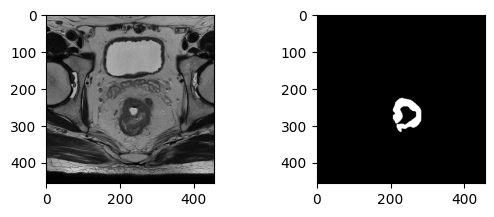

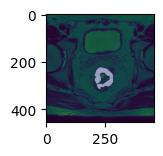

In [28]:

# image = cv2.imread(imgfile, cv2.IMREAD_UNCHANGED)
# image.shape
# image = np.reshape(image, (1, image.shape[0], image.shape[1])).transpose((1,2,0))
# image.shape
# image = torch.from_numpy(image)
# image = image.expand(-1, -1, 1)
# image.shape
# image = image.numpy()


# mask = cv2.imread(pngfile, cv2.IMREAD_GRAYSCALE)
# mask.shape
# mask = np.reshape(mask, (1, mask.shape[0], mask.shape[1])).transpose(1, 2, 0)
# mask.shape
# image


img_file_path = f'/home/workspace/AMP_mysef_2D_Cls/data/png_img_Tr_nonzero/crc_008/crc_008_012.png'
mask_file_path = f'/home/workspace/AMP_mysef_2D_Cls/data/png_mask_Tr_nonzero/crc_008/crc_008_012.png'

image = cv2.imread(img_file_path, cv2.IMREAD_UNCHANGED)
mask = cv2.imread(mask_file_path, cv2.IMREAD_UNCHANGED)
# image = np.reshape(image, (image.shape[0], image.shape[1], 1))
# image.shape
# image = torch.from_numpy(image)
# image = image.expand(-1, -1, 1)
# image.shape
# image = image.numpy()
image = image.astype(np.float32) / 255.0
mask = mask.astype(np.float32) / 255.0
mask_file = cv2.imread(mask_file_path, cv2.IMREAD_UNCHANGED)


########### print shape ################
print(image.shape)
print(np.unique(image))
print(mask_file.shape)
print(np.unique(mask))

############## subplot #################
plt.figure()
plt.subplot(221)
plt.imshow(image, cmap='gray')
 
plt.subplot(222)
plt.imshow(mask_file, cmap='gray')
plt.show()

plt.subplot(243)
plt.imshow(image)
plt.imshow(mask,alpha=0.5,cmap='gray')


In [51]:
import cv2
import torch
import numpy as np

In [56]:
image_size = 512
image_path = f'/home/workspace/AMP_mysef_2D_Cls/data/png_img_Tr_nonzero/crc_008/crc_008_012.png'
mask_path = f'/home/workspace/AMP_mysef_2D_Cls/data/png_mask_Tr_nonzero/crc_008/crc_008_012.png'

image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

image = cv2.resize(image, dsize=(image_size, image_size), interpolation=cv2.INTER_LINEAR)
mask  = cv2.resize(mask, dsize=(image_size, image_size), interpolation=cv2.INTER_LINEAR)

assert np.unique(mask).all() in [0, 255]

# pdb.set_trace()

image = image.astype(np.float32)/255
mask  = mask.astype(np.float32)/255

print('mask:', np.unique(mask))


assert np.unique(mask).all() in [0, 1]

# pdb.set_trace()

# if self.transforms is not None:
#     image, mask = self.transforms(image, mask)

# pdb.set_trace()


image = torch.from_numpy(image).float()
mask = torch.from_numpy(mask).float()

image1 = image.unsqueeze(0)
mask1 = mask.unsqueeze(0)

img_mask = torch.cat([
    image1,
    image1,
    image1,
    # torch.zeros([1, 512, 512]),
    # mask1,
], 0)
# img_mask = torch.cat([
#     image1,
#     torch.zeros([1, 512, 512]),
#     mask1,
# ], 0)

# pdb.set_trace()
# img_mask = img_mask.expand(3, -1, -1)
img_mask_np = img_mask.numpy().transpose(1, 2, 0)
img_mask_np.shape

mask: [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04705882
 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667 0.07058824
 0.07450981 0.07843138 0.09411765 0.09803922 0.10196079 0.10980392
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432 0.16470589
 0.16862746 0.17254902 0.18039216 0.18431373 0.1882353  0.19607843
 0.2        0.20392157 0.21176471 0.21568628 0.21960784 0.22352941
 0.22745098 0.23137255 0.23529412 0.24313726 0.24705882 0.2509804
 0.25490198 0.25882354 0.2627451  0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29803923 0.3019608  0.30588236
 0.30980393 0.3137255  0.31764707 0.32156864 0.33333334 0.3372549
 0.34117648 0.34509805 0.3529412  0.36078432 0.3647059  0.36862746
 0.37254903 0.38039216 0.38431373 0.3882353  0.39215687 0.39607844
 0.4        0.40392157 0.40784314 0.41568628 0.41960785 0.4

(512, 512, 3)

array([[[0.63529414, 0.63529414, 0.63529414],
        [0.64705884, 0.64705884, 0.64705884],
        [0.6431373 , 0.6431373 , 0.6431373 ],
        ...,
        [0.654902  , 0.654902  , 0.654902  ],
        [0.65882355, 0.65882355, 0.65882355],
        [0.67058825, 0.67058825, 0.67058825]],

       [[0.54509807, 0.54509807, 0.54509807],
        [0.59607846, 0.59607846, 0.59607846],
        [0.62352943, 0.62352943, 0.62352943],
        ...,
        [0.6862745 , 0.6862745 , 0.6862745 ],
        [0.6862745 , 0.6862745 , 0.6862745 ],
        [0.68235296, 0.68235296, 0.68235296]],

       [[0.46666667, 0.46666667, 0.46666667],
        [0.5254902 , 0.5254902 , 0.5254902 ],
        [0.5921569 , 0.5921569 , 0.5921569 ],
        ...,
        [0.67058825, 0.67058825, 0.67058825],
        [0.6666667 , 0.6666667 , 0.6666667 ],
        [0.6627451 , 0.6627451 , 0.6627451 ]],

       ...,

       [[0.00392157, 0.00392157, 0.00392157],
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0

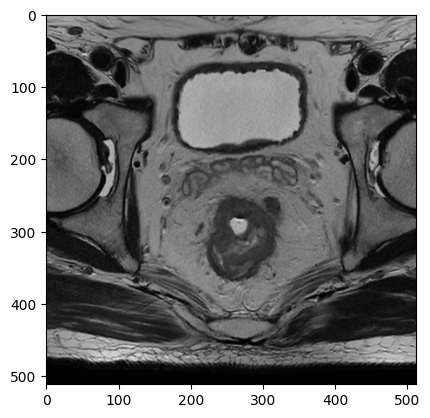

In [59]:
plt.imshow(img_mask_np, cmap='gray')
img_mask_np

In [35]:
np.unique(img_mask_np)

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568628,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313726, 0.04705882, 0.05098039, 0.05490196,
       0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.07450981,
       0.07843138, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
       0.09803922, 0.10196079, 0.10588235, 0.10980392, 0.11372549,
       0.11764706, 0.12156863, 0.1254902 , 0.12941177, 0.13333334,
       0.13725491, 0.14117648, 0.14509805, 0.14901961, 0.15294118,
       0.15686275, 0.16078432, 0.16470589, 0.16862746, 0.17254902,
       0.1764706 , 0.18039216, 0.18431373, 0.1882353 , 0.19215687,
       0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
       0.21568628, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
       0.23529412, 0.23921569, 0.24313726, 0.24705882, 0.2509804 ,
       0.25490198, 0.25882354, 0.2627451 , 0.26666668, 0.27058825,
       0.27450982, 0.2784314 , 0.28235295, 0.28627452, 0.29019

In [43]:
img_mask_np.shape

(512, 512, 3)

In [58]:
np.unique(img_mask_np[:, :, 1])

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568628,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313726, 0.04705882, 0.05098039, 0.05490196,
       0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.07450981,
       0.07843138, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
       0.09803922, 0.10196079, 0.10588235, 0.10980392, 0.11372549,
       0.11764706, 0.12156863, 0.1254902 , 0.12941177, 0.13333334,
       0.13725491, 0.14117648, 0.14509805, 0.14901961, 0.15294118,
       0.15686275, 0.16078432, 0.16470589, 0.16862746, 0.17254902,
       0.1764706 , 0.18039216, 0.18431373, 0.1882353 , 0.19215687,
       0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
       0.21568628, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
       0.23529412, 0.23921569, 0.24313726, 0.24705882, 0.2509804 ,
       0.25490198, 0.25882354, 0.2627451 , 0.26666668, 0.27058825,
       0.27450982, 0.2784314 , 0.28235295, 0.28627452, 0.29019